# Exploring Transformers
### We will use ResNet to find presence of substructures

#### Importing libraries

In [1]:
import torch, gc
import os
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt
%matplotlib inline


/home/anky/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Normalizing stats

In [2]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

#### Transormations added to normalize and flip images

In [6]:
train_tfms = tt.Compose([
                        tt.RandomHorizontalFlip(),
                        tt.RandomVerticalFlip(),
                        tt.RandomRotation(30),
                        tt.RandomAdjustSharpness(1.3),
                        tt.ToTensor(),
                        tt.Normalize(*stats,inplace=True)
                        ])
test_tfms = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

#### Creating training dataset and test dataset

In [7]:
train_ds = ImageFolder('data/train',train_tfms)
test_ds = ImageFolder('data/test',test_tfms)

#### Classes
##### 1)No substructures
##### 2)Substructures

In [8]:
train_ds.classes

['applauding_train',
 'blowing_bubbles_train',
 'brushing_teeth_train',
 'cleaning_the_floor_train',
 'climbing_train',
 'cooking_train',
 'cutting_trees_train',
 'cutting_vegetables_train',
 'drinking_train',
 'feeding_a_horse_train',
 'fishing_train',
 'fixing_a_bike_train',
 'fixing_a_car_train',
 'gardening_train',
 'holding_an_umbrella_train',
 'jumping_train',
 'looking_through_a_microscope_train',
 'looking_through_a_telescope_train',
 'phoning_train',
 'playing_guitar_train',
 'playing_violin_train',
 'pouring_liquid_train',
 'pushing_a_cart_train',
 'reading_train',
 'riding_a_bike_train',
 'riding_a_horse_train',
 'rowing_a_boat_train',
 'running_train',
 'shooting_an_arrow_train',
 'smoking_train',
 'taking_photos_train',
 'texting_message_train',
 'throwing_frisby_train',
 'using_a_computer_train',
 'walking_the_dog_train',
 'washing_dishes_train',
 'watching_TV_train',
 'waving_hands_train',
 'writing_on_a_board_train',
 'writing_on_a_book_train']

In [9]:
batch_size = 24

#### Specifying dataloaders

In [10]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
test_dl = DataLoader(test_ds,batch_size*2,num_workers=3,pin_memory=True)

##### Functions for denormalization and checking data

In [11]:
def denormalize(images,means,stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

def show_batch(dl):
    for images,labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]);ax.set_yticks([])
        denorm_images =  denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0).clamp(0,1))
        break

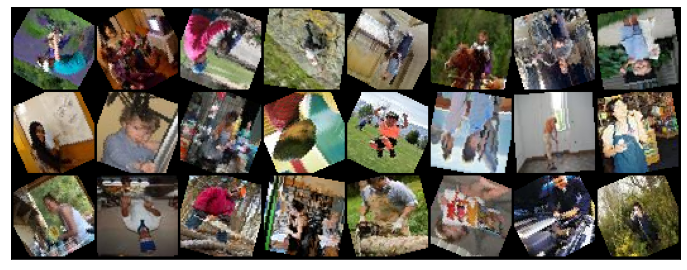

In [12]:
show_batch(train_dl)

#### Using GPU for computation

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

#### Loading dataloader to GPU

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

#### Functions for evaluation of diffrent parameters like accuracy and loss.

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        # saving model above 85% accuracy
        if epoch_acc.item() > 0.29:
            torch.save(model.state_dict(), 'res_lens_find_{}.pth'.format(epoch_acc.item()))
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Model RESNET

In [25]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.norm15 = nn.BatchNorm2d(15)
        self.norm30 = nn.BatchNorm2d(30)
        self.norm60 = nn.BatchNorm2d(60)
        self.norm120 = nn.BatchNorm2d(120)
        self.norm200 = nn.BatchNorm2d(200)
        self.norm300 = nn.BatchNorm2d(300)
        self.norm360 = nn.BatchNorm2d(360)
        self.norm512 = nn.BatchNorm2d(512)
        #--------------------
        self.conv15 = nn.Conv2d(3,15,kernel_size=3,stride=1,padding=1)#15x64x64
        self.conv30 = nn.Conv2d(15,30,kernel_size=3,stride=1,padding=1)#30x64x64
        self.conv60 = nn.Conv2d(30,60,kernel_size=3,stride=2,padding=1)#60x32x32

        self.res60 = nn.Conv2d(60,60,kernel_size=3,stride=1,padding=1)
        #---------------
        self.conv120a = nn.Conv2d(60,60,kernel_size=3,stride=1,padding=1)
        #------------
        self.conv200 = nn.Conv2d(60,200,kernel_size=3,stride=1,padding=1)#200x32x32
        self.conv200a = nn.Conv2d(200,200,kernel_size=3,stride=2,padding=1)#200x16x16
        

        self.res200 = nn.Conv2d(200,200,kernel_size=3,stride=1,padding=1)
        #------------------
        self.conv300 = nn.Conv2d(200,200,kernel_size=3,stride=1,padding=1)
        self.conv360 = nn.Conv2d(200,360,kernel_size=3,stride=1,padding=1)#360x16x16
        self.conv512 = nn.Conv2d(360,512,kernel_size=3,stride=1,padding=1)#512x16x16

        

        #===========================#
        self.pool = nn.MaxPool2d(2,2)
        self.avgpool = nn.AvgPool2d(2,2)
        self.flat = nn.Flatten()

        self.linear = nn.Linear(512*2*2,40)

    def forward(self,xb):
      out = torch.relu(self.norm15(self.conv15(xb)))#15x64x64

      out = torch.relu(self.norm30(self.conv30(out)))#30x64x64

      out = torch.relu(self.norm60(self.conv60(out)))#60x32x32

      x = self.res60(out)#120x32x32

      out = torch.relu(self.conv120a(out)+x)

      out = torch.relu(self.norm200(self.conv200(out)))

      out = torch.relu(self.conv200a(out))

      

      x = self.res200(out)

      out = torch.relu(self.conv300(out)+x)

      out = torch.relu(self.norm360(self.conv360(out)))

      out = torch.relu(self.norm512(self.conv512(out)))

      out = self.avgpool(out)#512x8x8
      out = self.avgpool(out)#512 4 4
      out = self.avgpool(out)#512 2 2
      
      out = self.flat(out)
      out = self.linear(out)

      return out




#### Clearing GPU cache

In [26]:
gc.collect()
torch.cuda.empty_cache()

#### Uploading model to GPU

In [27]:
model = to_device(ResNet9(3,2),device)
model

ResNet9(
  (norm15): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm30): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm60): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm120): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm200): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm300): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm360): BatchNorm2d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm512): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv15): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv30): Conv2d(15, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv60): Conv2d(30, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (res60): C

### Training Function

In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Training parameters

In [29]:
epochs = 300
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

### Training phase

In [30]:
ret_data = fit_one_cycle(epochs,max_lr,model,train_dl,test_dl,weight_decay,grad_clip,opt_func)

Epoch [0], last_lr: 0.00000, train_loss: 3.6893, val_loss: 3.6464, val_acc: 0.0618
Epoch [1], last_lr: 0.00000, train_loss: 3.6272, val_loss: 3.5981, val_acc: 0.0693
Epoch [2], last_lr: 0.00000, train_loss: 3.5745, val_loss: 3.5505, val_acc: 0.0663
Epoch [3], last_lr: 0.00000, train_loss: 3.5182, val_loss: 3.5108, val_acc: 0.0726
Epoch [4], last_lr: 0.00000, train_loss: 3.4706, val_loss: 3.4835, val_acc: 0.0824
Epoch [5], last_lr: 0.00001, train_loss: 3.4318, val_loss: 3.4523, val_acc: 0.0939
Epoch [6], last_lr: 0.00001, train_loss: 3.3972, val_loss: 3.4331, val_acc: 0.0921
Epoch [7], last_lr: 0.00001, train_loss: 3.3690, val_loss: 3.4102, val_acc: 0.0974
Epoch [8], last_lr: 0.00001, train_loss: 3.3421, val_loss: 3.4055, val_acc: 0.0953
Epoch [9], last_lr: 0.00001, train_loss: 3.3263, val_loss: 3.3846, val_acc: 0.1032
Epoch [10], last_lr: 0.00001, train_loss: 3.2979, val_loss: 3.3740, val_acc: 0.1030
Epoch [11], last_lr: 0.00001, train_loss: 3.2887, val_loss: 3.3592, val_acc: 0.1019
Ep

# Evaluate your own validation dataset.

In [28]:
torch.save(model.state_dict(),"weight_29.pth")

In [ ]:
def validate_results(path_to_validation_data):
    val_ds = ImageFolder(path_to_validation_data,test_tfms)
    val_dl = DataLoader(val_ds,batch_size=32,shuffle=True,num_workers=3,pin_memory=True)
    model = ResNet9(3,10)
    model.load_state_dict(torch.load("weights/REsnet_99.pth"))
    results = evaluate(model,val_dl)
    return results

print(validate_results("data/test"))

### Functions for plotting graphs

In [29]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Acc vs Epochs')

def plot_loss(history):
  loss = [x['val_loss'] for x in history]
  plt.plot(loss, '-x')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Loss vs Epochs')

def plot_lr(history):
  lr = [x['lrs'] for x in history]
  plt.plot(lr, '-x')
  plt.xlabel('epoch')
  plt.ylabel('learning_rates')
  plt.title('Learning_rates vs Epochs')

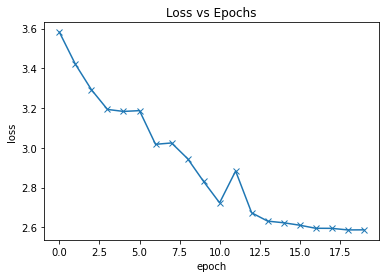

In [30]:
plot_loss(ret_data)

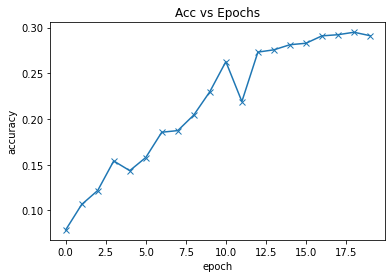

In [31]:
plot_accuracies(ret_data)

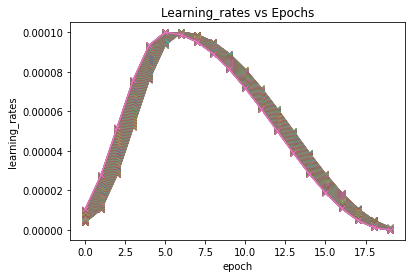

In [32]:
plot_lr(ret_data)

### Function for predicting Image

In [33]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    a, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])
Label: applauding_train , Predicted: applauding_train


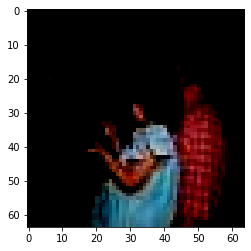

In [34]:
img, label = test_ds[45]
print(img.shape)
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))